# Finding Lane Lines on the Road

**Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on a video stream.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

---
## Project Requirements

### Required files

- Code submitted in a .zip file. If you write your project in a jupyter notebook, you can hand this in as a `.ipynb`file.
- Report in .pdf format. Try to hold it short and consistent.
- Your pipeline result on the videos [test_videos/solidWhiteRight.mp4](test_videos/solidWhiteRight.mp4), and [test_videos/solidYellowLeft.mp4](test_videos/solidYellowLeft.mp4). Should be saved in the folder `result_videos`, in `.mp4` format.
- (Optional) Your pipeline result on the challenging video, [test_videos/challenge.mp4](test_videos/challenge.mp4).  Should be saved in the folder `result_videos`, in `.mp4` format. 

### Result requirements
Your pipeline will be evaluated on [test_videos/solidWhiteRight.mp4](test_videos/solidWhiteRight.mp4), and [test_videos/solidYellowLeft.mp4](test_videos/solidYellowLeft.mp4). Potential bonus points will be given on the challenging video, [test_videos/challenge.mp4](test_videos/challenge.mp4).

**What we expect of your ouput is:**
- The output video is an annotated version of the input video.
- In a rough sense, the left and right lane lines are accurately annotated throughout almost all of the video. Annotations can be segmented or solid lines
- Visually, the left and right lane lines are accurately annotated by solid lines throughout most of the video.

**Example of expected output:**
Example of expected output can be seen in [examples/example_output.mp4](examples/example_output.mp4)

### Report requirements 
- Describe your pipeline
- Identify potential shortcomings with your current pipeline
- Suggest possible improvements to your pipeline

---

## Recommended tools:
We recommend you to use the following tools & packages:

- Numpy 
- Matplotlib
- Jupyter Notebook
- OpenCV
- Moviepy (To generate output videos)

If you're not familiar with python, matplotlib or numpy before, the standford CS231n class has a short crash course on these tools. You can find it here: [http://cs231n.github.io/python-numpy-tutorial/#numpy](http://cs231n.github.io/python-numpy-tutorial/#numpy)

### OpenCV useful functions 

- `cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)` to convert images to/from RGB/grayscale; use `cv2.COLOR_RGB2GRAY` or `cv2.COLOR_GRAY2RGB`.
- `cv2.Sobel(...)` to apply the sobel operator.
- `cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)` to apply a gaussian noise kernel.
- `cv2.Canny(image, low_threshold, high_threshold)` to apply the canny-edge detection algorithm.
- `cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)` to find hough lines in the given image.
- `cv2.erode`, `cv2.dilate`, etc.. You can read about this [here](https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_morphological_ops/py_morphological_ops.html).
- ...

These are some recommended functions to look into, but OpenCV is a powerful library with a lot more functions. You are free to experiment with anything that might solve this project, as long as you understand the underlying theory behind the tools you choose to use.

### Import packages

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
%matplotlib inline

### Available Data
    
The available data you have to test and fine tune your model can be found in [examples/](examples), and [test_videos/](test_videos). 
We recommend you to start to test your implementation on the images in [examples/](examples). 

When you have a good implementation on the images, you should test your implementation on [test_videos/solidWhiteRight.mp4](test_videos/solidWhiteRight.mp4), and [test_videos/solidYellowLeft.mp4](test_videos/solidYellowLeft.mp4). We expect your implementation to work well on these two examples. 

We also provide a challenge video for those who want improve their model; [test_videos/challenge.mp4](test_videos/challenge.mp4). Try your lane finding pipeline on the video.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!



This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


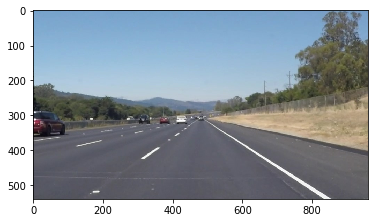

In [2]:
#reading in an image
image = plt.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

### Basic Sobel thresholding

Text(0.5,1,'Grayscale Image')

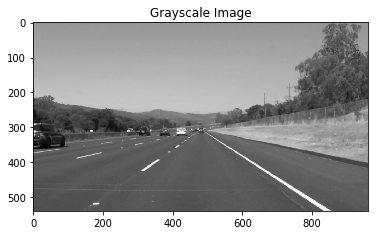

In [3]:
grayscale = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
plt.imshow(grayscale, cmap="gray")
plt.title("Grayscale Image")

Here we apply the Sobel operator to detect edges in our image, first in x-direction, then the y-direction. You can read more about the Sobel Operator in OpenCV [here](https://docs.opencv.org/2.4/doc/tutorials/imgproc/imgtrans/sobel_derivatives/sobel_derivatives.html).

In [4]:
sobelx = cv2.Sobel(grayscale, cv2.CV_64F, dx=1, dy=0, ksize=5)
sobely = cv2.Sobel(grayscale, cv2.CV_64F, dx=0, dy=1, ksize=5)

#### Visualize our results

Text(0.5,1,'Sobel Y')

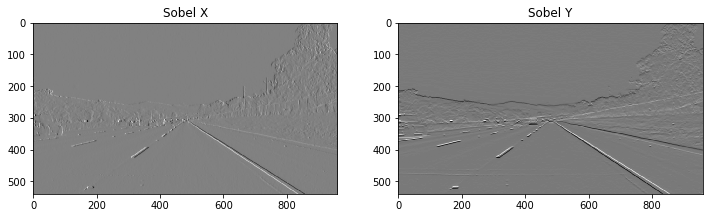

In [5]:
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.title("Sobel X")
plt.imshow(sobelx, cmap="gray")
plt.subplot(1,2,2)
plt.imshow(sobely, cmap="gray")
plt.title("Sobel Y")

Finally, we threshold the sobely image to find edges in the y-direction

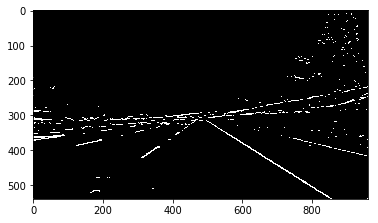

In [6]:
sobely_threshold = sobely > 900
plt.imshow(sobely_threshold, cmap="gray")

### Region of interest masking
In our image there is only a small part we are actually interested in. By knowing this, we can mask out the top part of the image, as well as parts on the left/right side. This is known as region of interest masking.

In [7]:
# This function applies region of interest masking
# Given an image, and vertices of a polygon it zeros out everything outisde our region of interest
# vertices shape: (1, n, 2) where n is number of points.
def roi_masking(image, vertices):
    mask = np.zeros_like(image).astype(np.uint8)
    # cv2.FillPoly is a simple function to generate a mask in our wanted region of interst
    mask = cv2.fillPoly(mask, vertices, 255)
    masked_image = image*mask
    return masked_image

Text(0.5,1,'Final Result')

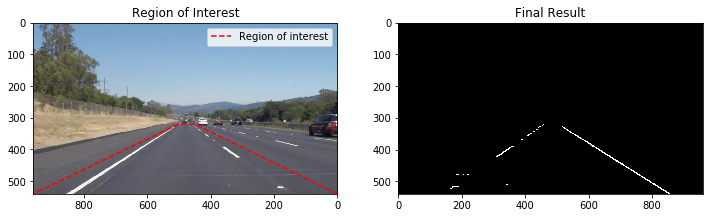

In [8]:
# Define our Region of Interest with a 4-point polygon
# Vertices given in (x, y) 
vertices = np.array([[
    [0, 540], # (x, y)
    [450, 320],
    [500, 320],
    [960, 540]
]])
masked_sobely = roi_masking(sobely_threshold, vertices)
plt.figure(figsize=(12,8))

# Plot original image with labeled region of interest
plt.subplot(1,2,1)
plt.imshow(image, cmap="gray")
plt.xlim([image.shape[1], 0 ])
plt.ylim([image.shape[0], 0])
plt.plot(vertices[0, :, 0], vertices[0, :, 1], '--r', label="Region of interest")
plt.legend()
plt.title("Region of Interest")

# Plot masked result
plt.subplot(1,2,2)
plt.imshow(masked_sobely, cmap="gray")
plt.title("Final Result")


## Generating videos

In [9]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import glob
import os

In [10]:
def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """    x = np.concatenate((y, np.ones_like(y)), axis=1)
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    assert(img.shape == initial_img.shape,
    "The two images has to be the same shape. Img shape: {}, initial_img shape: {}".format(img.shape, initial_img.shape)
          ) 
    return cv2.addWeighted(initial_img, α, img, β, γ)

# This function takes in a single image, and returns an RGB image. 
# We will use this function to generate our final video with moviepy. 
# Implement your whole pipeline in this function, and return your final result.
# Be sure to return an RGB Image, and not grayscale. (This is required by moviepy). 
def process_image(image):
    
    #### TODO: REPLACE THIS CODE
    # Here is my simple implementation to find edges in the X-direction.
    # We require you to implement your whole pipeline here. 
    grayscale = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    sobely = cv2.Sobel(grayscale, cv2.CV_64F, 0, 1, ksize=5)
    sobely_threshold = sobely > 900 
    vertices = np.array([[
        [0, 540],
        [450, 320],
        [500, 320],
        [960, 540]
    ]])
    sobely_threshold = roi_masking(sobely_threshold, vertices)
    rgb_img = cv2.cvtColor(sobely_threshold, cv2.COLOR_GRAY2RGB)
    
    red = np.zeros_like(image)
    red[:, :, 0] = sobely_threshold
    color = weighted_img(red, image)
    return color

### Test your pipeline
Here you might want to test your implementation on several of the images in the testing folder

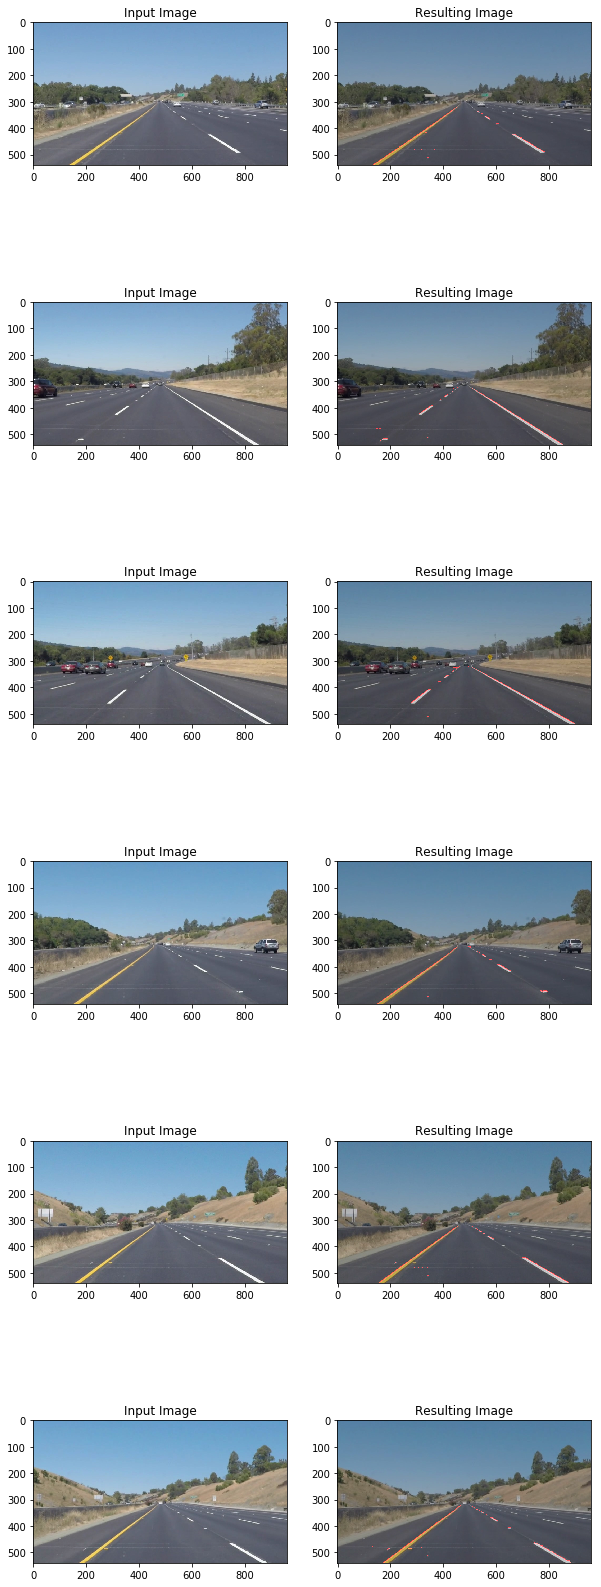

In [11]:
plt.figure(figsize=(10,30))
images = glob.glob("test_images/*.jpg")
n = len(images)
for idx, impath in enumerate(images):
    image = plt.imread(impath)
    plt.subplot(n,2,idx*2+1)
    plt.imshow(image)
    plt.title("Input Image")
    result = process_image(image)
    plt.subplot(n,2,idx*2+2)
    plt.title("Resulting Image")
    plt.imshow(result)

### Final result: Generate .mp4 file

In [12]:
white_output = 'results/solidWhiteRight.mp4'
os.makedirs("results", exist_ok=True)
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4") # Change the filepath to test on another video
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video results/solidWhiteRight.mp4
[MoviePy] Writing video results/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:04<00:00, 50.12it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: results/solidWhiteRight.mp4 

CPU times: user 3.55 s, sys: 1.49 s, total: 5.04 s
Wall time: 5.06 s


In [18]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

### Analyze image
To find out issues of your pipeline you might want to look at the result in different parts of your pipeline.
This is one way to do it.

In [19]:
def analyze_image(image):
    height, width = image.shape[:2]
    grayscale = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    sobely = cv2.Sobel(grayscale, cv2.CV_64F, 1, 0, ksize=5)
    sobely_threshold = sobely > 900 
    
    # Region of Interest

    sobely_threshold_masked = roi_masking(sobely_threshold, vertices)

    # Create square of images
    result = np.zeros((image.shape[0]*2, image.shape[1]*2, 3))
    result[:height, :width, :] = image
    
    # Right upper corner
    img = (sobely_threshold*255).astype('uint8')
    result[:height, width:, :] = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    
    # Left down corner
    sobely_threshold_masked = (sobely_threshold_masked / sobely_threshold_masked.max() *255).astype(np.uint8)
    img = cv2.cvtColor(sobely_threshold_masked, cv2.COLOR_GRAY2RGB)
    result[height:, :width, :] = img
    #print(i.shape)
    
    # Right down corner
    red = np.zeros_like(image)
    red[:, :, 0] = sobely_threshold_masked
    color = weighted_img(red, image)
    result[height:, width:, :] = color
    
    return result

In [20]:
white_output = 'results/solidWhiteRight_analyzis.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(analyze_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video results/solidWhiteRight_analyzis.mp4
[MoviePy] Writing video results/solidWhiteRight_analyzis.mp4


100%|█████████▉| 221/222 [00:11<00:00, 20.41it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: results/solidWhiteRight_analyzis.mp4 

CPU times: user 38.2 s, sys: 7.91 s, total: 46.2 s
Wall time: 11.9 s


In [21]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Useful functions
Here are some useful functions which we haven't used in this walkthrough, but might be required to implement your pipeline

In [22]:

def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the extracted .
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img
